# Procrastinate Pro+ Entertainment App Analytics

#### Task Description

Despite huge investments in advertising, the company has been experiencing losses over the past few months.  
The task is to identify the reasons and help the company return to profitability.  

Based on the provided data on user visits, orders, and advertising costs, the plan is to:  
1. Process the data  
2. Evaluate advertising expenses by channels and periods  
3. Calculate LTV/RR/CAC/ROI metrics, both overall and for groups by channels/regions/devices  
4. Provide general recommendations and conclusions  

### Load the data and prepare it for analysis

Load the data on visits, orders, and advertising costs from CSV files into variables.  

**File paths**

- visits: `/datasets/visits_info_short.csv`. [Download dataset](https://code.s3.yandex.net/datasets/visits_info_short.csv)  
- orders: `/datasets/orders_info_short.csv`. [Download dataset](https://code.s3.yandex.net/datasets/orders_info_short.csv)  
- costs: `/datasets/costs_info_short.csv`. [Download dataset](https://code.s3.yandex.net/datasets/costs_info_short.csv)  

Explore the data and perform preprocessing. Check for missing values and duplicates. Make sure that the data types in all columns correspond to their contents. Pay special attention to the columns with date and time.  

In [69]:
from scipy import stats as st
from math import factorial
from scipy.stats import binom
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

In [70]:
#загружаем датасет
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    ad_costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    ad_costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [71]:
events = None

In [72]:
# check basic info about visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [73]:
# check basic info about orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [74]:
# check basic info about costs
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Data Preprocessing

In the dataframes, the column names need to be renamed and the date columns should be converted to the proper format.  

In [75]:
# convert column names to a consistent format
visits = (visits
.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device'
                , 'Channel': 'channel', 'Session Start': 'session_start', 'Session End': 'session_end'}) 
)
orders = (orders
.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'}) 
)
ad_costs = (ad_costs
.rename(columns={'dt': 'dt', 'Channel': 'channel', 'costs': 'costs'}) 
)

In [76]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])

In [77]:
# check visits data for missing values
visits.isna().sum().sort_values(ascending=False)

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [78]:
# check orders data for missing values
orders.isna().sum().sort_values(ascending=False)

user_id     0
event_dt    0
revenue     0
dtype: int64

In [79]:
# check costs data for missing values
ad_costs.isna().sum().sort_values(ascending=False)

dt         0
channel    0
costs      0
dtype: int64

Check that all changes have been applied correctly

In [80]:
visits.head(5)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [81]:
orders.head(5)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [82]:
ad_costs.head(5)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [83]:
# check for obvious duplicates
print(visits.duplicated().sum())
print(orders.duplicated().sum())
ad_costs.duplicated().sum()

0
0


0

In [84]:
# remove duplicates in the costs dataframe
ad_costs = ad_costs.drop_duplicates()
ad_costs.duplicated().sum()

0

In [85]:
# check platform names for potential hidden duplicates
visits['device'].sort_values().unique()

array(['Android', 'Mac', 'PC', 'iPhone'], dtype=object)

In [86]:
ad_costs['channel'].sort_values().unique()

array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
       'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
       'YRabbit', 'lambdaMediaAds'], dtype=object)

In [87]:
# check for missing values
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [88]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [89]:
ad_costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

#### Conclusion for this section:
1. Date data types were converted in all three dataframes.  
2. No missing values were found.  
3. Explicit duplicates were removed from `ad_costs`.  
4. All text values were converted to lowercase.  
5. No hidden duplicates were found.  

### Define functions for calculating and analyzing LTV, ROI, retention, and conversion.

You can use the functions introduced in the theoretical lessons.

Functions for calculating metric values:
- `get_profiles()` — to create user profiles  
- `get_retention()` — to calculate Retention Rate  
- `get_conversion()` — to calculate conversion  
- `get_ltv()` — to calculate LTV  

Functions for building charts:
- `filter_data()` — to smooth the data  
- `plot_retention()` — to plot Retention Rate  
- `plot_conversion()` — to plot conversion  
- `plot_ltv_roi()` — to visualize LTV and ROI  

#### User Profiles Function

In [90]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # sort sessions by user ID and acquisition date
    # group by ID to get the parameters of the first visits
    profiles = (sessions
                .sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg({'session_start': 'first','channel': 'first','device': 'first','region': 'first'})
                .rename(columns={'session_start': 'first_ts'})
                .reset_index()
               )

    # for cohort analysis, define the date of the first visit
    # and the first day of the month when it happened
    profiles['dt'] = pd.to_datetime(profiles['first_ts']).dt.normalize()
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # add a flag for paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # count the number of unique users
    # with the same acquisition source and date
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        # the column with the number of users will be called unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # return dt and channel from indexes
        )
    new_users['dt'] = pd.to_datetime(new_users['dt']).dt.normalize()

    # merge ad costs with the number of acquired users
    # by acquisition date and channel
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # divide advertising costs by the number of acquired users
    # save the results in the acquisition_cost (CAC) column
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # add acquisition cost to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
        )

    # organic users are not linked to advertising data,
    # so their acquisition_cost column contains NaN values
    # replace them with zero, since their acquisition cost is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles  # return profiles with CAC

#### Retention Function

In [91]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # decide which columns to keep for retention grouping, the payer flag is always included
    dimensions = ['payer'] + dimensions
    
    # filter out all users who could not "live" until the horizon 
    # (joined later than observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # create raw dataset
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # function for grouping by selected dimensions
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # build the "triangular table" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # determine cohort sizes
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # join cohort sizes with the triangular table
        result = result.div(result['cohort_size'], axis = 0)                                                     # divide each column by cohort size — calculate retention rate
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # keep only observations up to the horizon and the cohort_size column
        result['cohort_size'] = cohort_sizes                                                                     # reassign cohort_size column, since during division it turned into 1
        return result
    
    # calculate retention
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # calculate retention by all parameters + date
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # return retention tables and raw data (to allow debugging if necessary)
    return result_raw, result_grouped, result_in_time

#### Conversion Function

In [92]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # merge purchase data into profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohort if dimensions is empty
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # function to group the table by desired dimensions
    def group_by_dimensions(df, dims, horizon_days):
        # build a "triangular" conversion table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # calculate cumulative sum for each row
        result = result.fillna(0).cumsum(axis = 1)
        # compute cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # add cohort sizes into the conversion table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each cell by cohort size to get conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # keep only lifetimes within the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort sizes
        result['cohort_size'] = cohort_sizes
        return result

    # get conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # for conversion dynamics table, remove 'cohort' from dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # get conversion dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

#### LTV Function

In [93]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # filter out users who could not "survive" until the horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # merge purchases with profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group all users into one cohort if no dimensions specified
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # helper function for grouping and calculating metrics
    def group_by_dimensions(df, dims, horizon_days):
        # build cumulative revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)

        # calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # merge cohort sizes into result
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # calculate LTV
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        # calculate CAC
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculate ROI = LTV / CAC
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    # calculate grouped LTV and ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # calculate dynamics LTV and ROI
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,      # raw data
        result_grouped,  # LTV table
        result_in_time,  # LTV dynamics table
        roi_grouped,     # ROI table
        roi_in_time      # ROI dynamics table
    )

#### Chart Smoothing Function

In [94]:
def filter_data(df, window):
    # apply rolling mean for each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

# Example usage:
# window = 7
# filter_data(report, window).plot(grid=True)
# plt.title('Smoothing window width: {}'.format(window))
# plt.xlabel('Acquisition date')
# plt.show()

#### Retention Plot Function

In [95]:
def plot_retention(retention, retention_history, horizon, window=7):

    # set grid size for charts
    plt.figure(figsize=(15, 10))

    # exclude cohort sizes and day 0 retention
    retention = retention.drop(columns=['cohort_size', 0])
    # in the dynamics table keep only the required lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # if retention index has only payer, add second attribute — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # charts grid: 2 columns × 2 rows = 4 cells
    # first: retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # second: retention curves for non-paying users
    # share vertical axis with first chart
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # third: retention dynamics of paying users
    ax3 = plt.subplot(2, 2, 3)
    # get column names for pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter data and plot
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title(
        'Retention dynamics of paying users on day {}'.format(
            horizon
        )
    )

    # fourth: retention dynamics of non-paying users
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filter data and plot
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title(
        'Retention dynamics of non-paying users on day {}'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Conversion Plot Function

In [96]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # set grid size for charts
    plt.figure(figsize=(15, 5))

    # exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # in the dynamics table keep only the required lifetime
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first chart — conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    # second chart — conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # columns of the pivot table will be all index columns except date
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User conversion dynamics on day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

#### LTV/ROI Plot Function

In [97]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # set grid for plotting
    plt.figure(figsize=(20, 10))

    # drop cohort sizes from ltv table
    ltv = ltv.drop(columns=['cohort_size'])
    # keep only the required lifetime in ltv dynamics table
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # extract CAC into a separate dataframe
    cac_history = roi_history[['cac']]

    # drop cohort sizes and cac from roi table
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # keep only the required lifetime in roi dynamics table
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # first chart — ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # second chart — ltv dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # pivot table columns will be all index columns except date
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('LTV dynamics on day {}'.format(horizon))

    # third chart — cac dynamics
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title('CAC dynamics')

    # fourth chart — roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # fifth chart — roi dynamics
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Acquisition date')
    plt.title('ROI dynamics on day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Channel Grouping Function

In [98]:
# function to define channel groups
def channels_group(row):
    try:
        if 'WahooNetBanner' in row:
            return 'Others'
        elif 'OppleCreativeMedia' in row:
            return 'Others'     
        elif 'RocketSuperAds' in row:
            return 'Others'
        elif 'LeapBob' in row:
            return 'Others'
        elif 'MediaTornado' in row:
            return 'Others'
        elif 'YRabbit' in row:
            return 'Others'
        else:
            return row
    except:
         pass

### Exploratory Data Analysis

- Build user profiles. Identify the minimum and maximum acquisition dates.  
- Find out which countries users come from and which country has the largest share of paying users. Create a table showing the number of users and the share of paying users by country.  
- Analyze which devices clients use and which devices are preferred by paying users. Create a table showing the number of users and the share of paying users for each device.  
- Explore advertising sources and determine which channels brought the largest number of paying users. Create a table showing the number of users and the share of paying users for each acquisition channel.  

After each step, formulate conclusions.  

In [99]:
# get user profiles
users = get_profiles(visits,orders,ad_costs)

print(users.head(5))

    user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

                month  payer  acquisition_cost  
0 2019-05-07 20:58:57   True          1.088172  
1 2019-07-09 12:46:07  False          1.107237  
2 2019-10-01 09:58:33  False          0.000000  
3 2019-08-22 21:35:48  False          0.988235  
4 2019-10-02 00:07:44  False          0.230769  


In [100]:
# determine the maximum and minimum acquisition dates
min_date = users['first_ts'].min()
print('Minimum acquisition date:', min_date)
max_date = users['first_ts'].max()
print('Maximum acquisition date:', max_date)

Minimum acquisition date: 2019-05-01 00:00:41
Maximum acquisition date: 2019-10-27 23:59:04


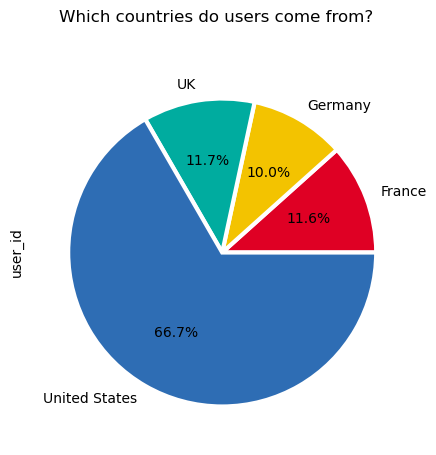

In [101]:
(users
.pivot_table(index='region',values='user_id',aggfunc='nunique')
.plot(kind='pie',figsize=(5, 5), legend=False,
      title='Which countries do users come from?', subplots=True, autopct='%1.1f%%',
      wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white'}, colors = ['#DF0024','#F3C300','#00AC9F','#2E6DB4'])
);

Users come from the USA, France, and Germany.

In [102]:
# check the share of paying users by country
users.groupby('region').agg({'payer':'mean','user_id':'nunique'}).sort_values(by='payer', ascending=False)

,payer,user_id
region,,
United States,0.069019,100002
Germany,0.041119,14981
UK,0.039829,17575
France,0.037994,17450


American users account for more than all other countries combined (about 50%).  
Accordingly, their average share of paying users (7%) is higher than in other countries.  
The average shares of paying users from the other countries are approximately the same (around 4%).  

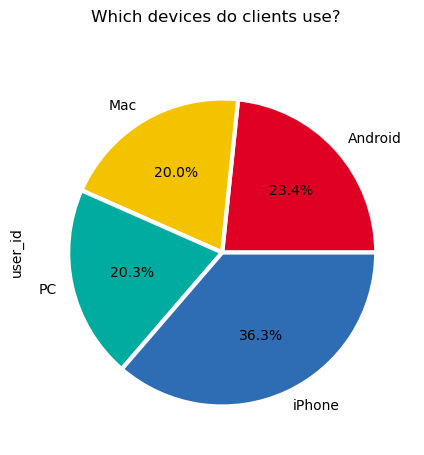

In [103]:
(users
.pivot_table(index='device',values='user_id',aggfunc='nunique')
.plot(kind='pie',figsize=(5, 5), legend=False,
      title='Which devices do clients use?', subplots=True, autopct='%1.1f%%',
      wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white'}, colors = ['#DF0024','#F3C300','#00AC9F','#2E6DB4'])
);

In [104]:
# check the share of paying users by device
users.groupby('device').agg({'payer':'mean','user_id':'nunique'}).sort_values(by='payer', ascending=False)

,payer,user_id
device,,
Mac,0.063644,30042
iPhone,0.062079,54479
Android,0.058518,35032
PC,0.050468,30455


Paying users prefer iPhone and Mac.  
Android and PC users pay in the app about 0.5–1% less.  

In [105]:
df_users = users.pivot_table(index='channel',values='user_id',aggfunc='nunique')
df_users.columns = ['users_count']

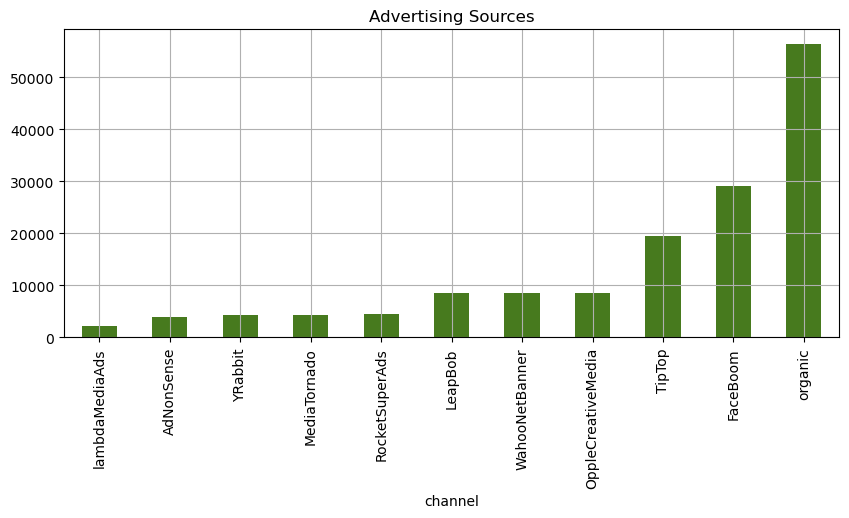

In [106]:
df_users.sort_values(by='users_count').plot(
    kind='bar',
    figsize=(10, 4),
    legend=False,
    title='Advertising Sources',
    color=['#477A1E'],
    grid=True
);

There are the most "organic" clients, followed by the FaceBoom channel, and then TipTop.  

In [107]:
# check the share of paying users by acquisition channels
users.groupby('channel').agg({'payer':'mean','user_id':'nunique'}).sort_values(by='payer', ascending=False)

,payer,user_id
channel,,
FaceBoom,0.122049,29144
AdNonSense,0.113402,3880
lambdaMediaAds,0.104700,2149
TipTop,0.096007,19561
RocketSuperAds,0.079137,4448
WahooNetBanner,0.052964,8553
YRabbit,0.038265,4312
MediaTornado,0.035747,4364
LeapBob,0.030633,8553


The most paying clients are acquired through the FaceBoom channel.  
Almost the same share (about 1% less) of paying clients comes from AdNonSense and lambdaMediaAd, even though these channels bring the fewest users overall.  
Organic clients pay the least.  

#### Conclusion for this section:
1. American users account for more than all other countries combined (about 50%).  
   Accordingly, their average share of paying users (7%) is higher than in other countries.  
2. Paying users prefer iPhone and Mac.  
3. Most users are acquired organically.  
4. The most paying clients are acquired through the FaceBoom channel.  
5. AdNonSense and lambdaMediaAd attract fewer users overall but nearly the most paying ones.  

### Marketing

- Calculate the total marketing spend.  
- Analyze how expenses are distributed across advertising sources — i.e., how much money was spent on each source.  
- Visualize the dynamics of changes in spending over time (by weeks and months) for each source. Try to show this on a single chart.  
- Find out the average cost of acquiring one user (CAC) from each source using user profiles.  

Write intermediate conclusions after each step.  

In [108]:
# total marketing spend
users['acquisition_cost'].sum()

105497.29999999999

In [109]:
# marketing spend by each acquisition source
ad_costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [110]:
# average customer acquisition cost (CAC) by each source
users.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [111]:
users_stat = (users.groupby(['channel','dt']).agg({'acquisition_cost':'sum'})
          .sort_values(by='acquisition_cost', ascending=False).reset_index()
         )

In [112]:
users_stat['month'] = users_stat['dt'].astype('datetime64[M]')
users_stat['week'] = users_stat['dt'].astype('datetime64[W]')

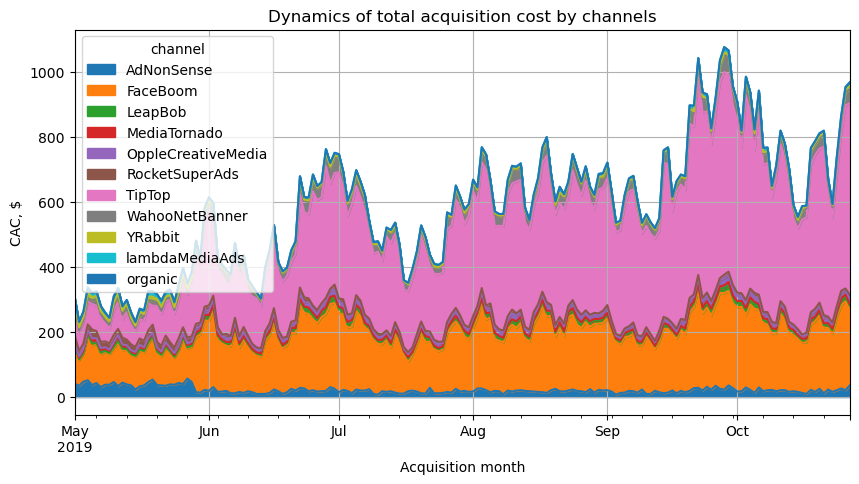

In [113]:
users_stat.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot.area(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Acquisition month')
plt.title('Dynamics of total acquisition cost by channels')
plt.show()

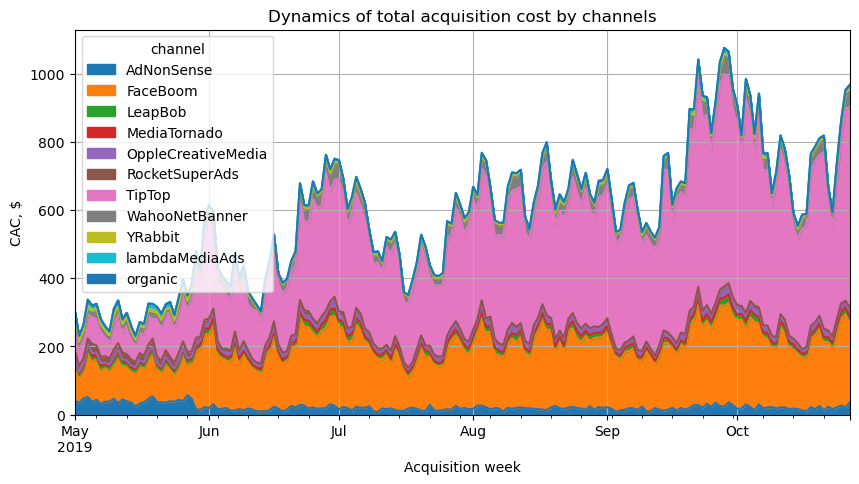

In [114]:
users_stat.pivot_table(
    index='week', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot.area(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Acquisition week')
plt.title('Dynamics of total acquisition cost by channels')
plt.show()

#### Conclusion for this section:
1. A total of $105K was spent on advertising, with almost half of it allocated to the TipTop channel.  
2. The second highest spending was on FaceBoom (about half as much as TipTop), followed by WahooNetBanner.  
3. The cost of acquiring one client (CAC) was the highest for TipTop (3 times higher than others), followed by FaceBoom and AdNonSense.  
4. Spending on TipTop increased significantly every 5 weeks and remained about 3 times higher than other channels throughout the period.  
5. Spending on FaceBoom and AdNonSense channels remained stable.  

### Evaluate Advertising Payback

Using LTV, ROI, and CAC charts, analyze the payback of advertising. Assume the calendar date is November 1, 2019, and the business plan requires users to break even no later than two weeks after acquisition. Decide independently whether to include organic users in the analysis.

- Analyze advertising payback using LTV and ROI charts, as well as the dynamics of LTV, CAC, and ROI.
- Check user conversion and its dynamics. Do the same for user retention. Build and examine conversion and retention charts.
- Analyze advertising payback by devices. Build LTV and ROI charts, as well as dynamics charts for LTV, CAC, and ROI.
- Analyze advertising payback by countries. Build LTV and ROI charts, as well as dynamics charts for LTV, CAC, and ROI.
- Analyze advertising payback by acquisition channels. Build LTV and ROI charts, as well as dynamics charts for LTV, CAC, and ROI.
- Answer the following questions:
    - Does advertising aimed at user acquisition pay off overall?
    - Which devices, countries, and acquisition channels may negatively impact advertising payback?
    - What might be causing payback issues?

Write a conclusion, describe possible causes of the identified problems, and provide interim recommendations for the marketing department.

In [115]:
# apply the channel grouping function for the chart
report = users.query('channel != "organic"')
report['channel'] = report['channel'].apply(channels_group)

/var/folders/0p/6cn9nyyd3zvgt2s7ftgpcj200000gn/T/ipykernel_46593/791598528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report['channel'] = report['channel'].apply(channels_group)


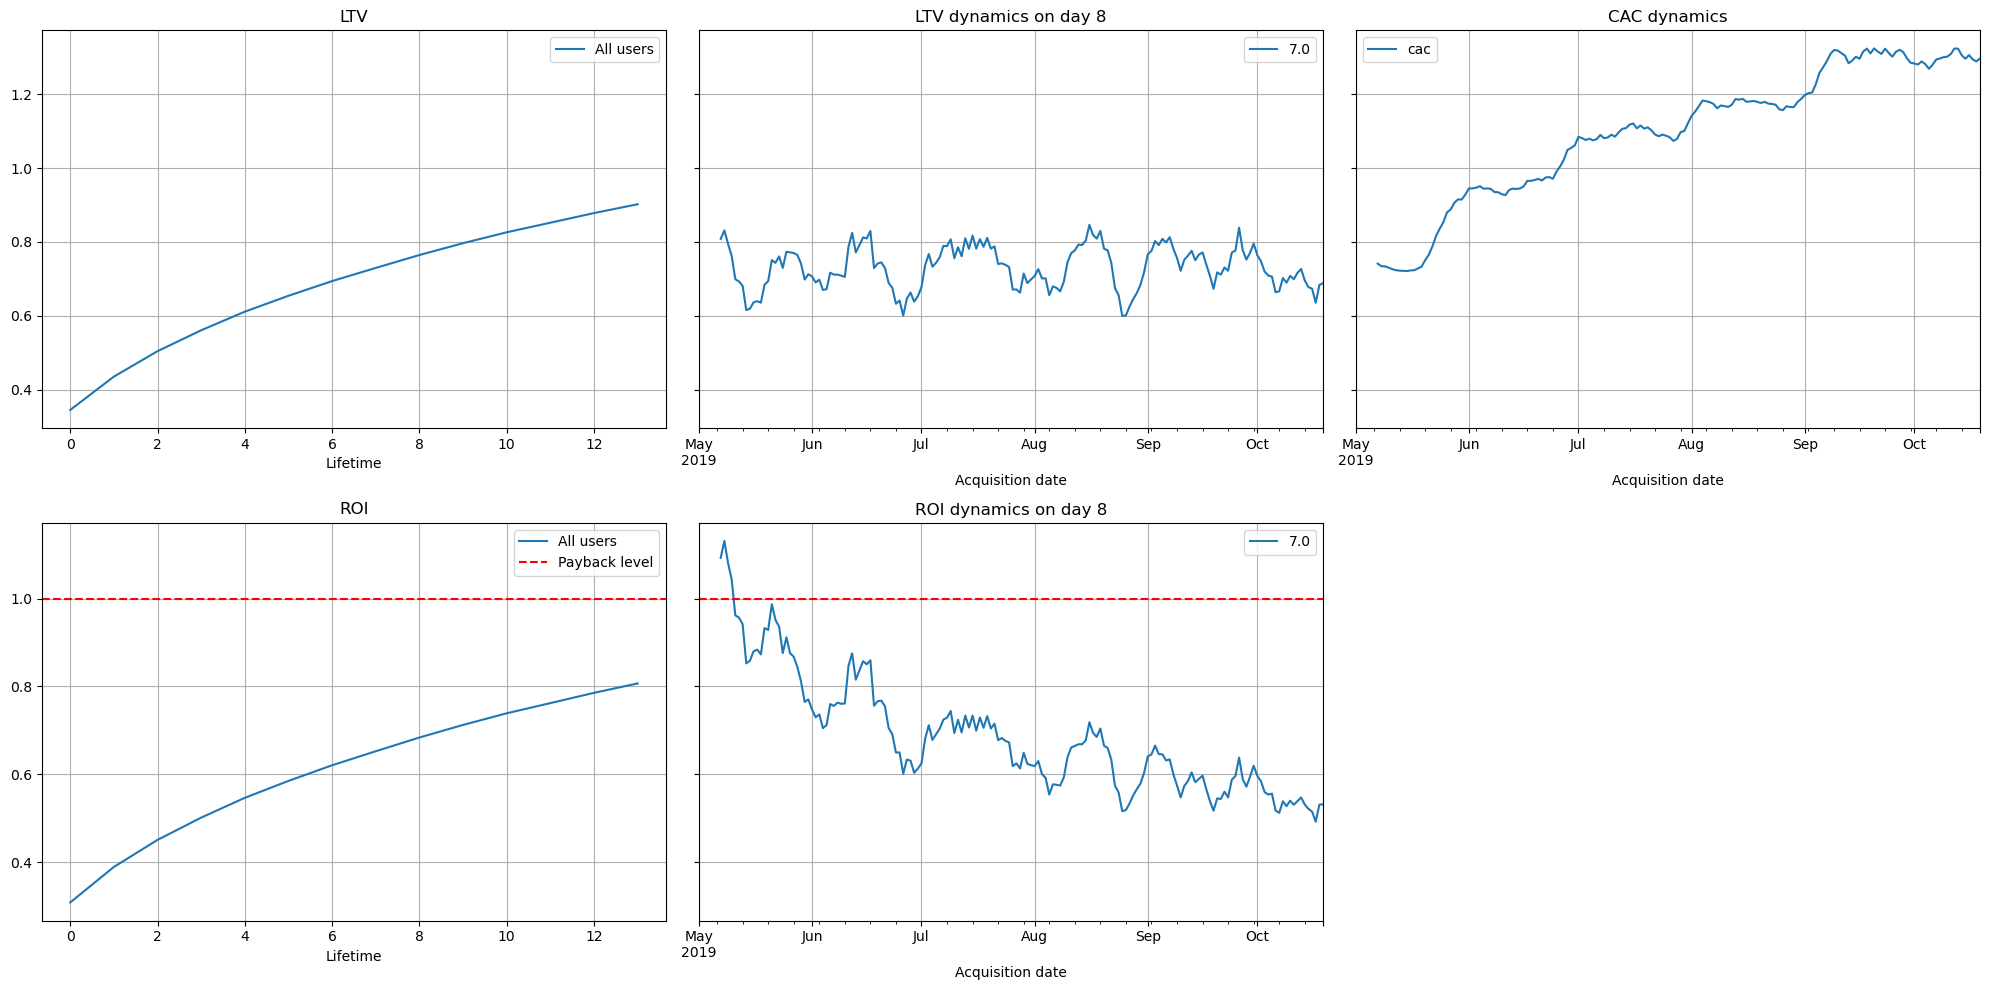

In [116]:
# calculate LTV, CAC, and ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    report,
    orders,
    datetime(2019, 11, 1).date(),
    14
)

# plot charts
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 8)

1. LTV looks acceptable: by the end of the second week it grows from 15% to 70%.  
2. The dynamics of LTV on day 8 show a monthly drop of about 10% toward the end, possibly linked to subscription renewal.  
3. CAC increased by 30% in June compared to May and continued to grow, +70% compared to the beginning of the reporting period.  
4. ROI is close but does not reach the payback threshold by the end of the second week. Advertising is not profitable.  
5. Looking at the 8th-day dynamics over a six-month horizon, it can be concluded that marketing cost-effectiveness is declining. The last "successful" advertising investment period was in May, coinciding with the rise in CAC. Likely, starting in May, more expensive channels were purchased that did not bring in paying clients.  

In [117]:
# call the function
retention_raw, retention, retention_history = get_retention(
    report , visits, datetime(2019, 11, 1).date(), 14
)

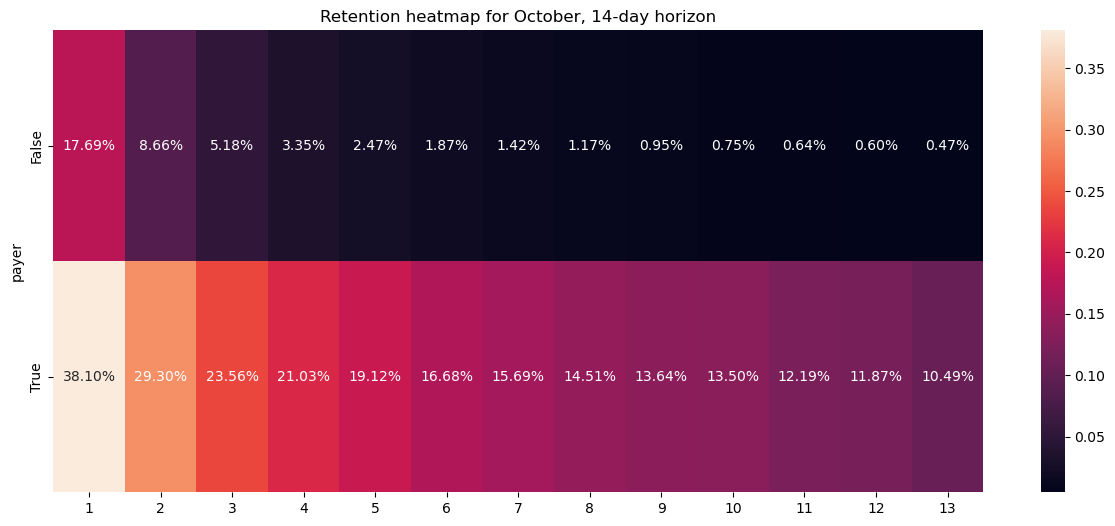

In [118]:
plt.figure(figsize=(15, 6))  # set chart size
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  # remove cohort sizes
    annot=True,  # show annotations
    fmt='.2%',  # display values as percentages
)
plt.title('Retention heatmap for October, 14-day horizon')  # chart title
plt.show()

1. Overall, paying users show better retention — which is expected. Their first-day retention is strong.  
2. RR for paying users drops by about 10% right after the first day, similar to non-paying users.  

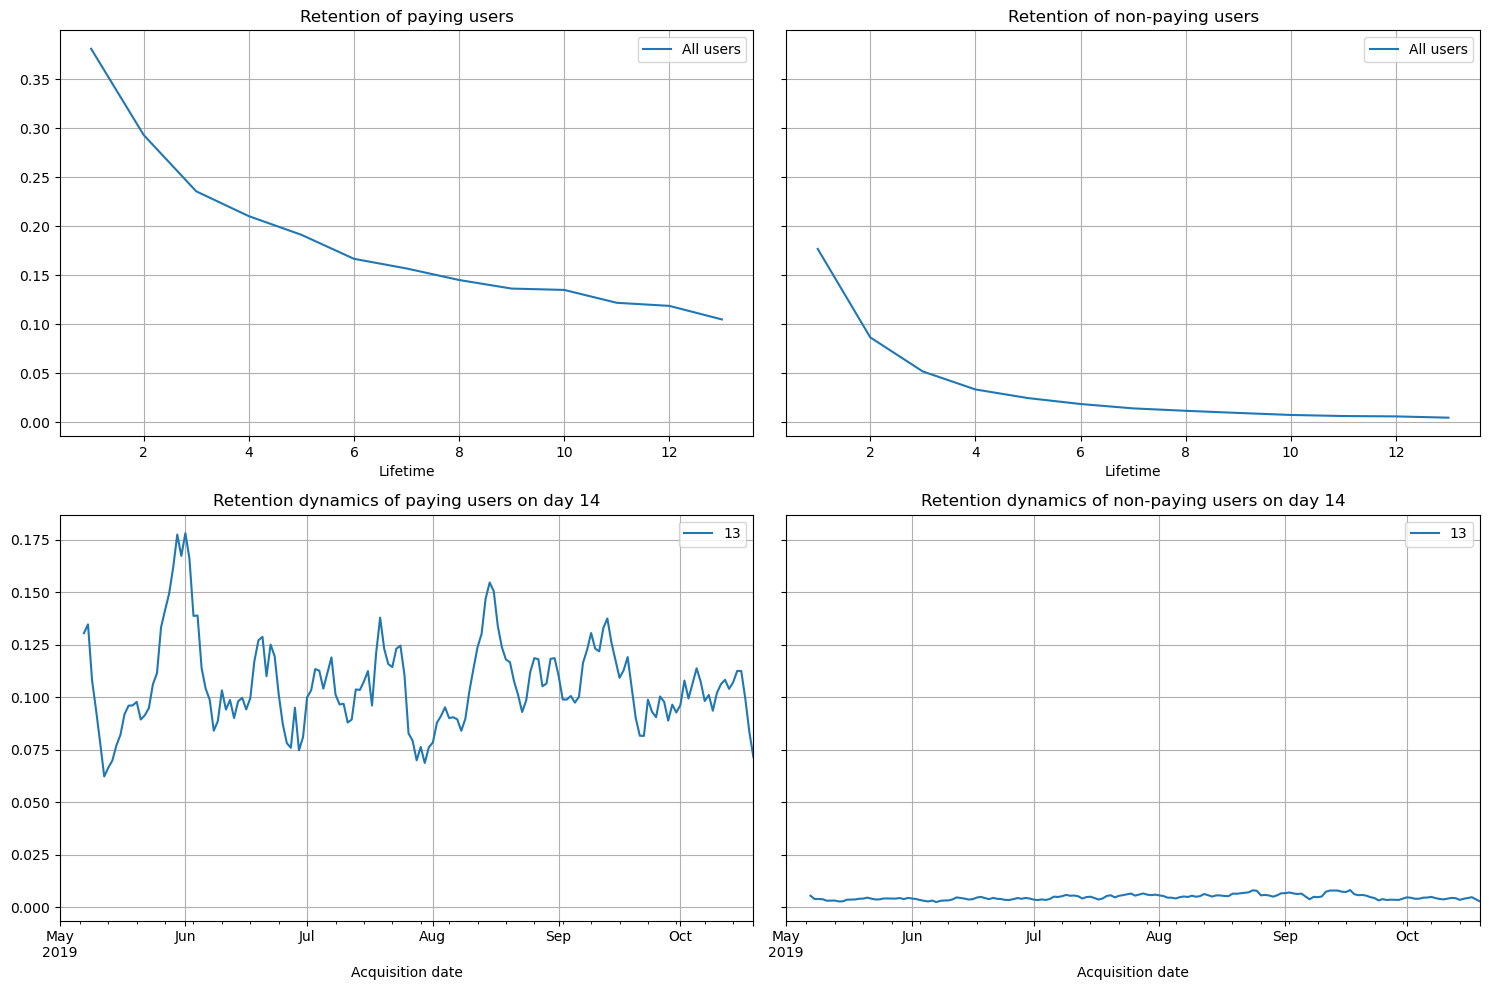

In [119]:
plot_retention(retention,retention_history, 14);

1. By the end of the second week, RR for paying users gradually declines, just like RR for non-paying users.  
2. The highest RR by the end of the second week for paying users was observed in early June and late May — right before advertising spending significantly increased. This could indicate that either a new feature was launched (and promoted) but failed to resonate, or that advertising attracted users who are harder to retain, even if some are willing to pay.  
3. RR of non-paying users can be seen as a potential growth point, since most users are acquired organically.  

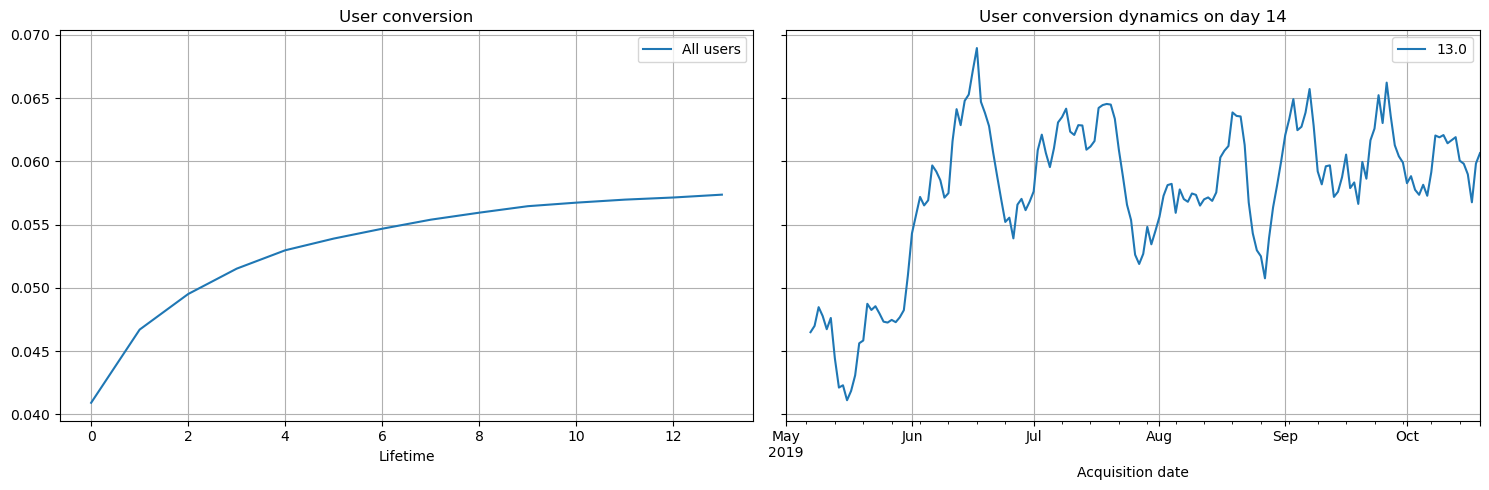

In [120]:
conversion_raw, conversion, conversion_history = get_conversion(
    users, orders, datetime(2019, 11, 1).date(), 14, 
)

plot_conversion(conversion, conversion_history, 14, window=7)

1. User conversion on the first day is low — about 4%, gradually increasing to 6% by the end of the second week.  
2. Overall conversion has grown since June, coinciding with the increase in the advertising budget.  

#### Devices:

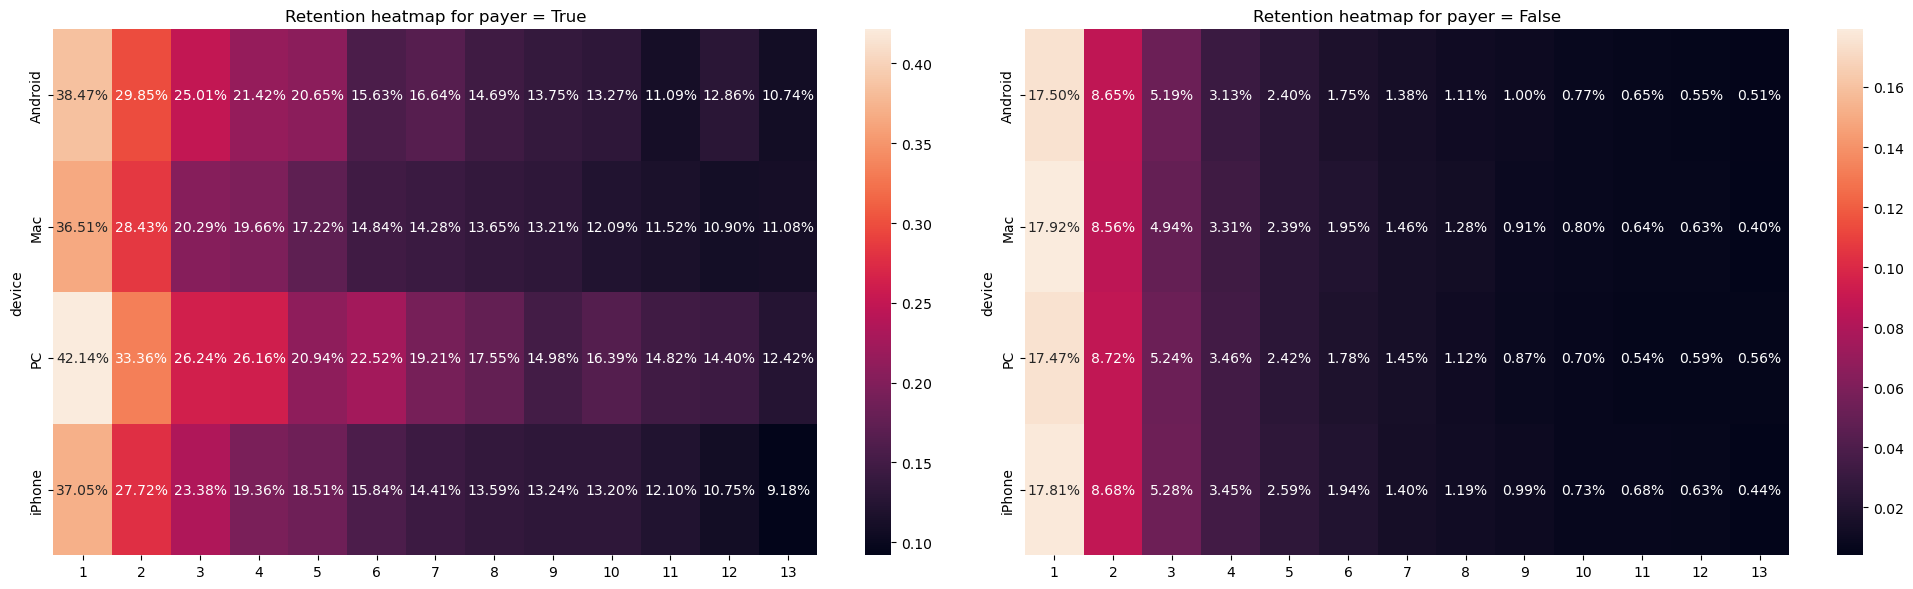

In [121]:
# call the function again with breakdown by devices
retention_raw, retention_dev, retention_dev_history = get_retention(
    report, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plt.figure(figsize=(20, 6))  # set grid size for charts

for i, payer in enumerate(report['payer'].unique()):
    sns.heatmap(
        retention_dev.query('payer == @payer')
        # remove payer from index to avoid clutter
        .droplevel('payer')
        # exclude cohort sizes and day 0 retention
        .drop(columns=['cohort_size', 0]),
        # show values
        annot=True,
        # format as percentages
        fmt='.2%',
        # plot each chart in its own cell
        ax=plt.subplot(1, 2, i + 1),
    )
    # set chart titles including payer value
    plt.title('Retention heatmap for payer = {}'.format(payer))

plt.tight_layout()  # adjust chart sizes to fit labels
plt.show()

1. Retention of PC users among paying clients is much higher compared to users of other devices.  
2. Android users also show good retention.  

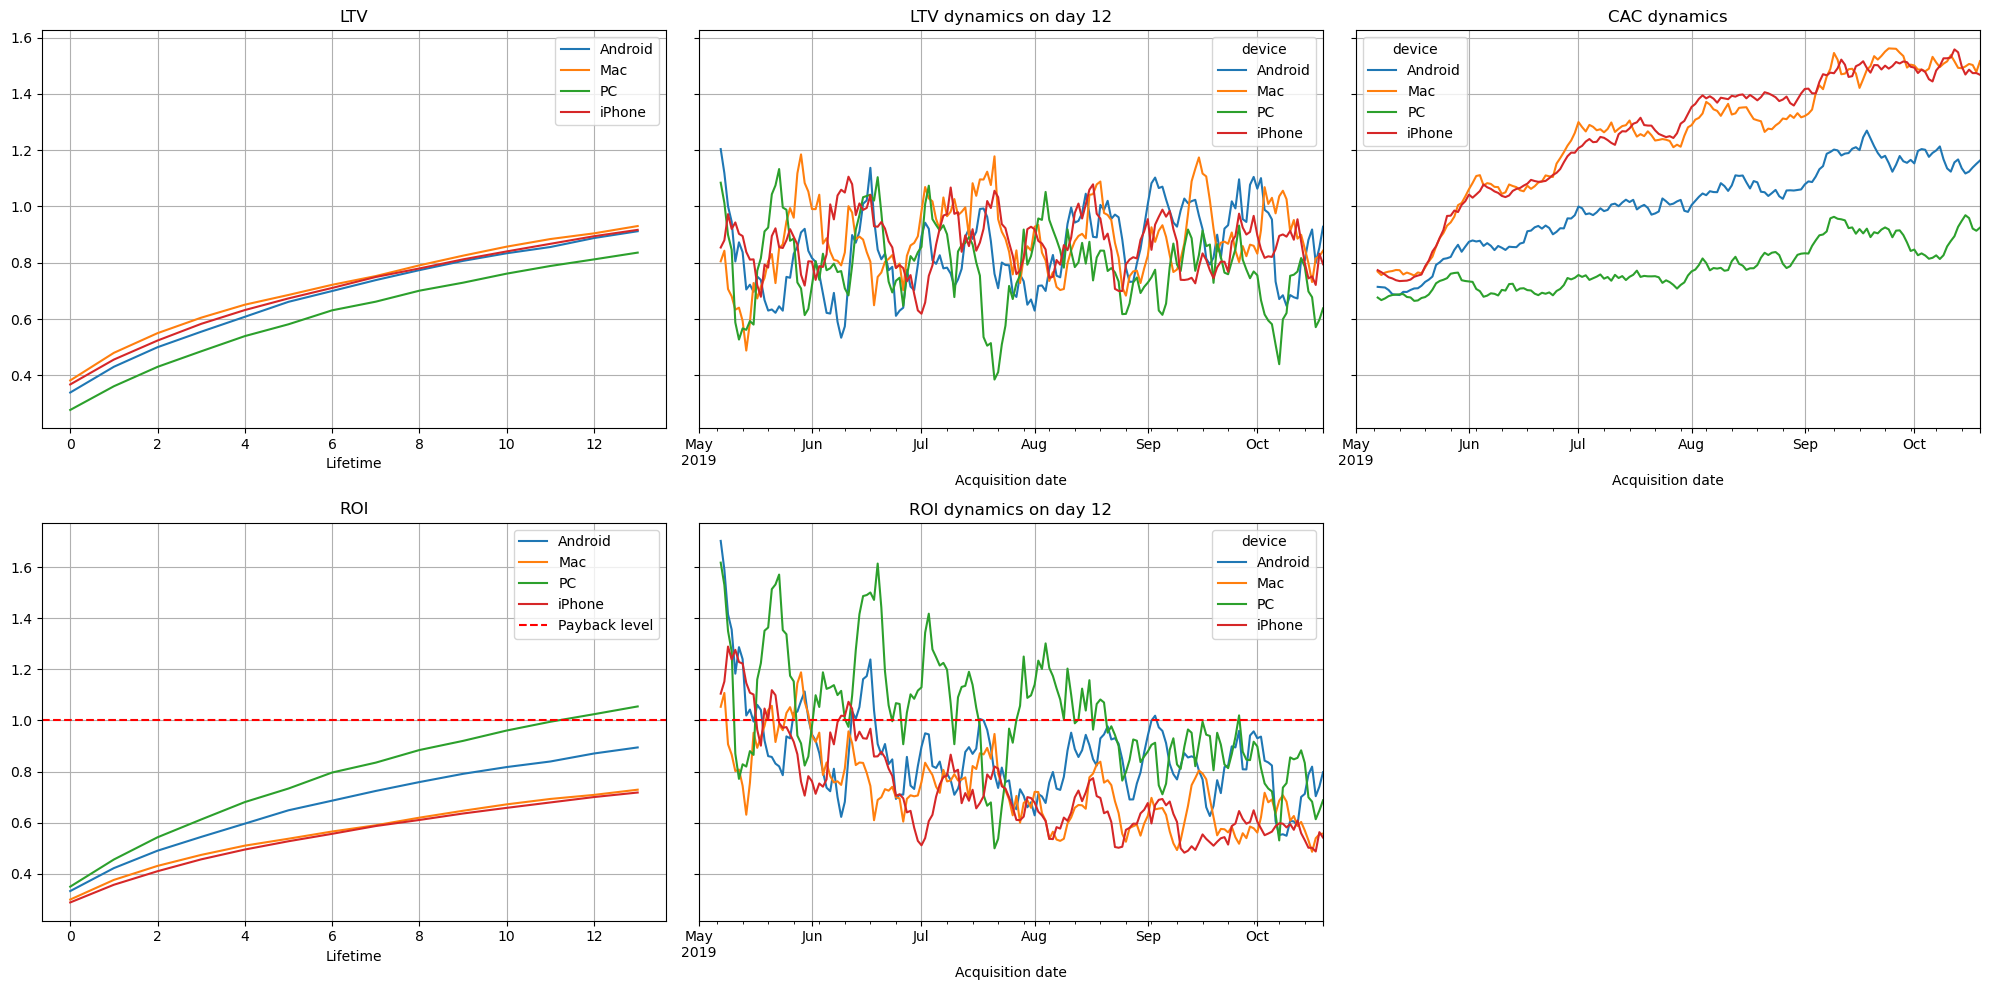

In [122]:
# calculate LTV, CAC, and ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    report,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['device'],
)

# plot charts
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 12)

1. By the end of the second week, LTV is similar across all devices: about 0.9 for Android/Mac/iPhone and 0.8 for PC.  
2. Over time, PC users show the largest LTV variation — about 0.5 units.  
3. In May, CAC was roughly the same across all devices — about 0.8 units. By mid-October, the highest CAC was for Mac and iPhone users (1.4 units), and the lowest for PC users.  
4. ROI exceeds 1 only for PC users at the 2-week horizon.  
5. The ROI dynamics chart shows that iPhone/Mac users’ ROI steadily declined month by month, while the PC group remained at the payback level the longest, until mid-August.  

#### Regions:

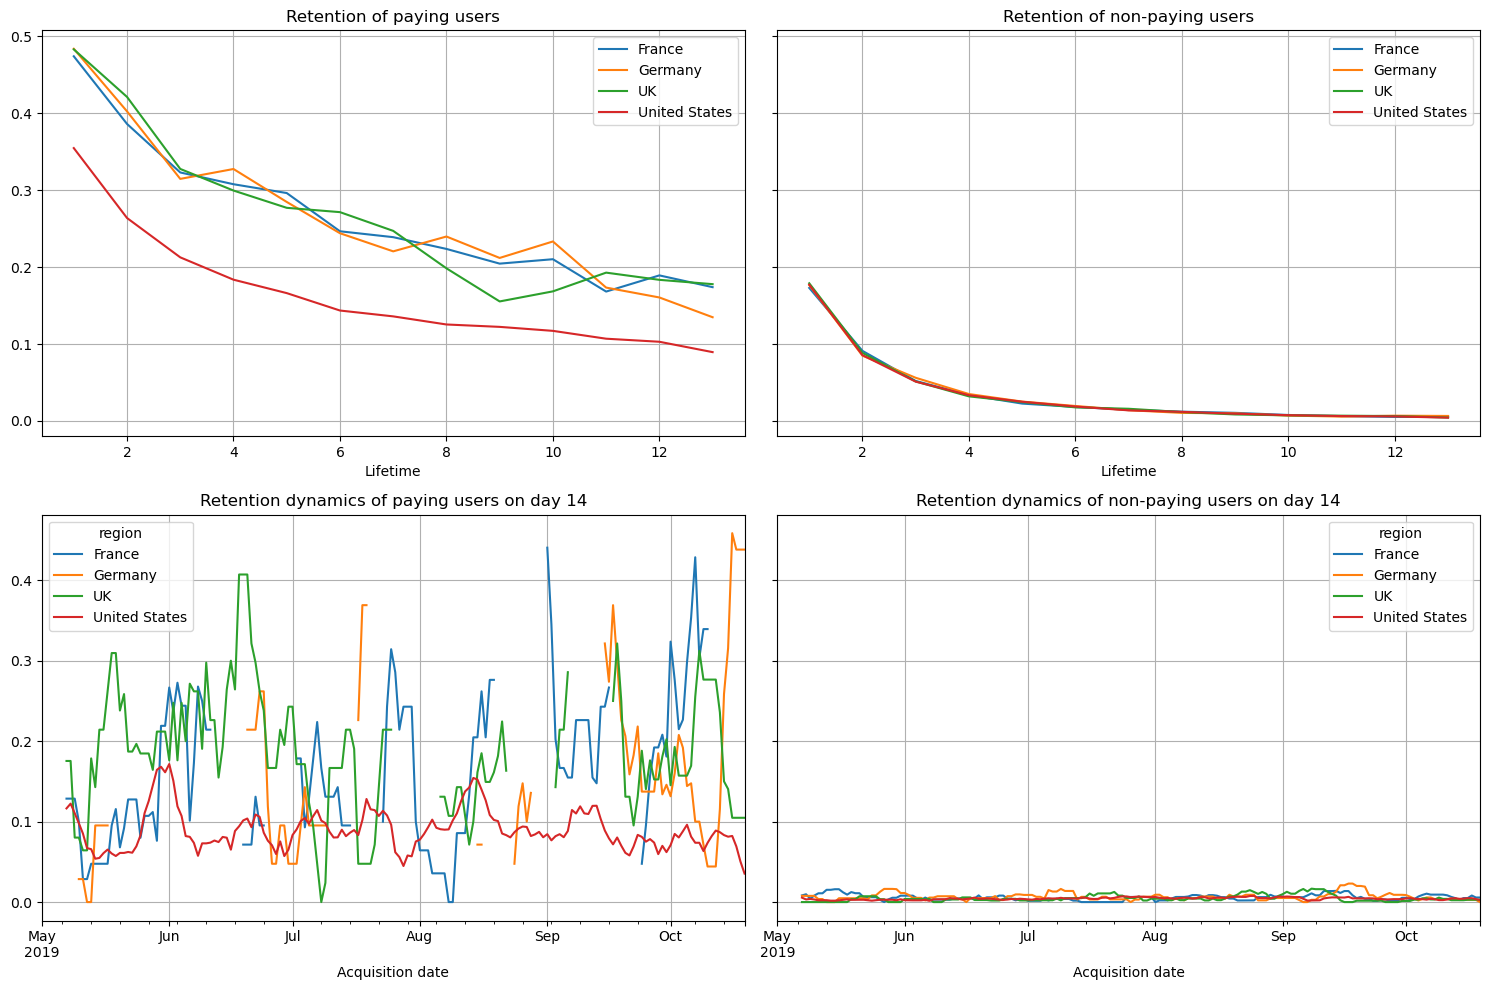

In [123]:
# call the function again with breakdown by regions
retention_raw, retention_reg, retention_reg_history = get_retention(
    report , visits, datetime(2019, 11, 1).date(), 14,dimensions=['region']
)

plot_retention(retention_reg,retention_reg_history, 14);

1. Retention of users from the USA is the lowest, even though they represent the largest and most paying segment. Organic users are not included in this chart.  
2. The dynamics show that retention of paying US users has been lower than others since May and remains low. The best retention is observed among users from the UK and Germany.  

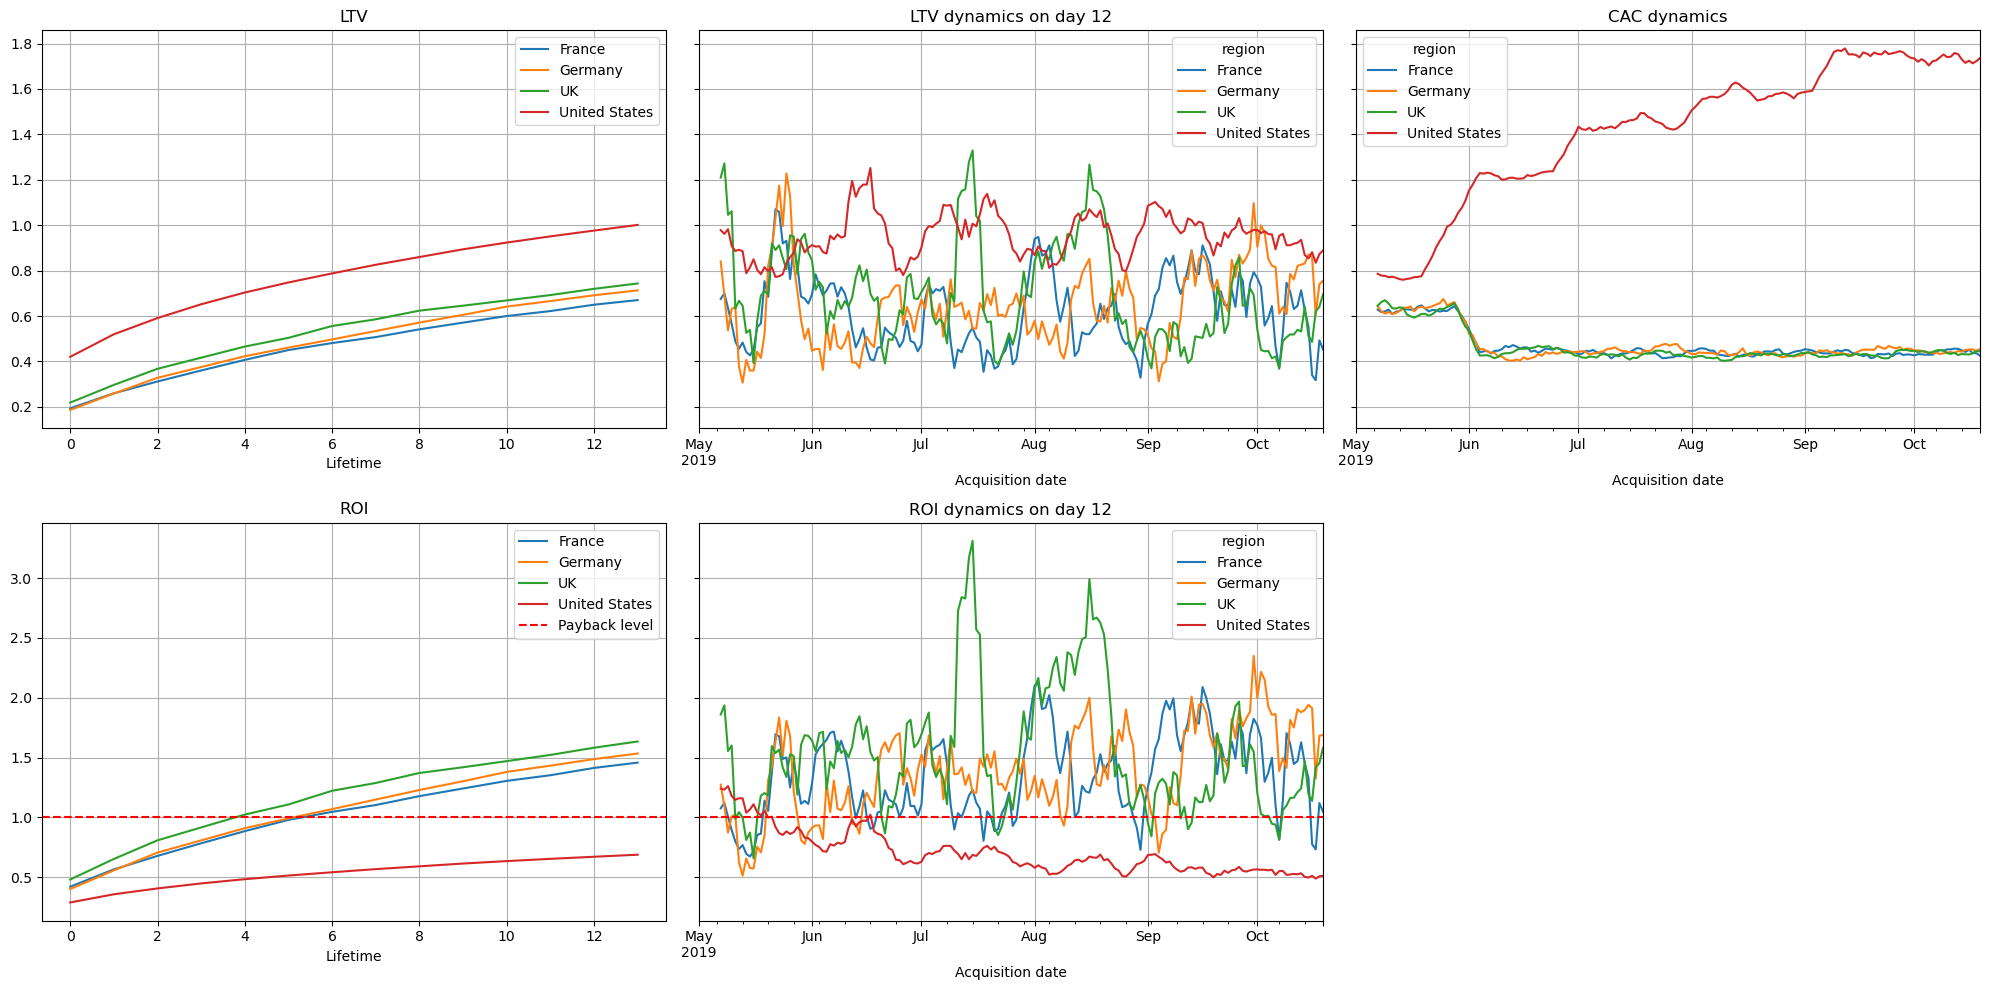

In [124]:
# calculate LTV, CAC, and ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    report,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['region'],
)

# plot charts
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 12)

1. LTV of US users is the highest; other regions generate about the same.  
2. Over the entire period, LTV was highest among US and UK users.  
3. The cost of acquiring US users is almost 60% higher than others, while their retention is weak. Acquisition costs rose sharply starting in June (with increased ad spending).  
4. Acquisition of US users does not pay off by the end of the second week. In the dynamics, users from other regions reach payback, while US users did so only until June.  

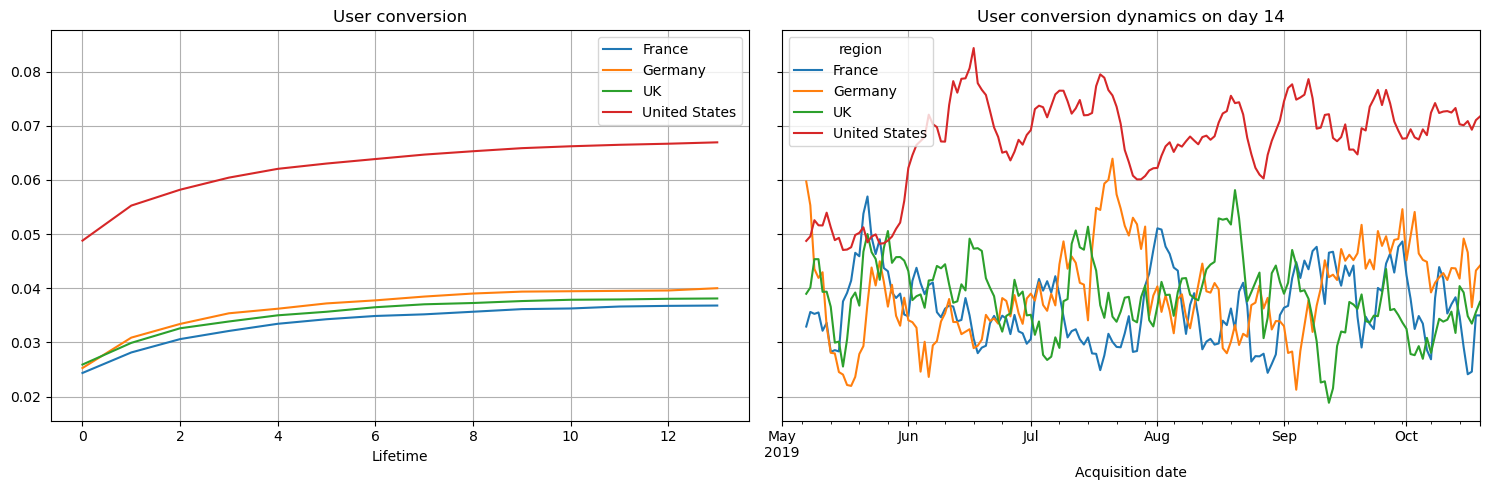

In [125]:
conversion_raw, conversion_reg, conversion_reg_history = get_conversion(
    users, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

plot_conversion(conversion_reg, conversion_reg_history, 14, window=7)

1. Conversion of US users is 40% higher than others, reaching nearly 70% by the end of the second week — a strong result. In dynamics, US users also show consistently high conversion levels throughout the period.  
2. Other regions have similar indicators on both charts. French users show the weakest conversion.  

#### Channels:

In [126]:
# call the function again with breakdown by channels
retention_raw, retention_ch, retention_ch_history = get_retention(
    report , visits, datetime(2019, 11, 1).date(), 14,dimensions=['channel']
)

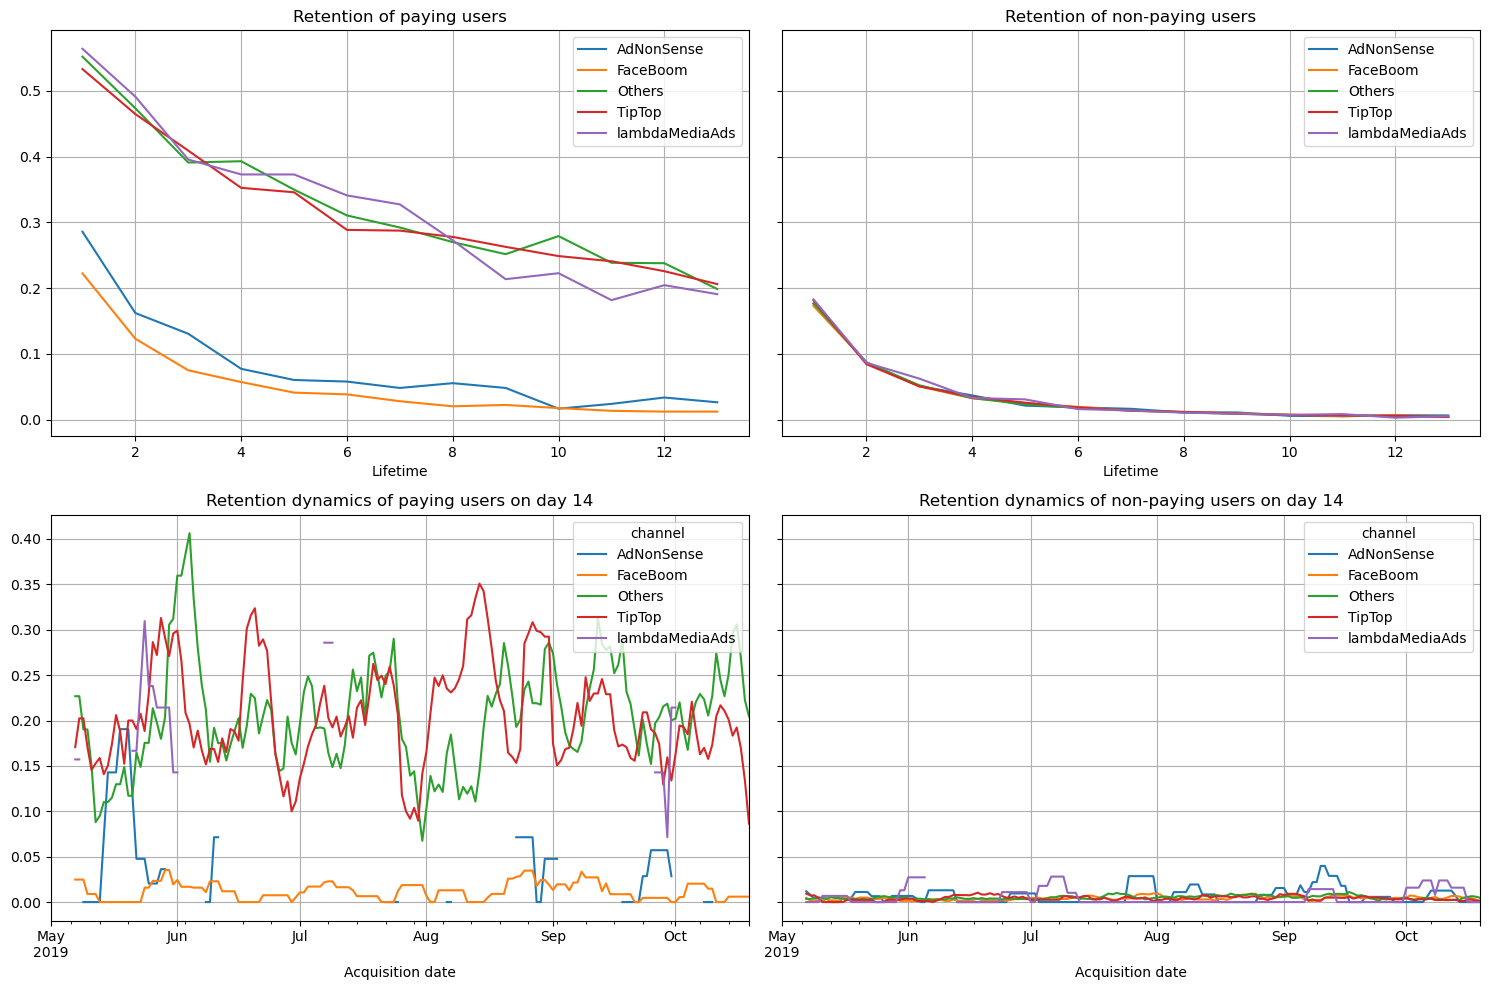

In [127]:
plot_retention(retention_ch,retention_ch_history, 14);

1. Retention is highest among users acquired through the TipTop channel — comparable to the combined retention level of four other channels. The second place goes to AdNonSense, which brings in the most paying clients.  
2. In the dynamics, TipTop also shows high RR, while the FaceBoom channel stands out with low retention.  

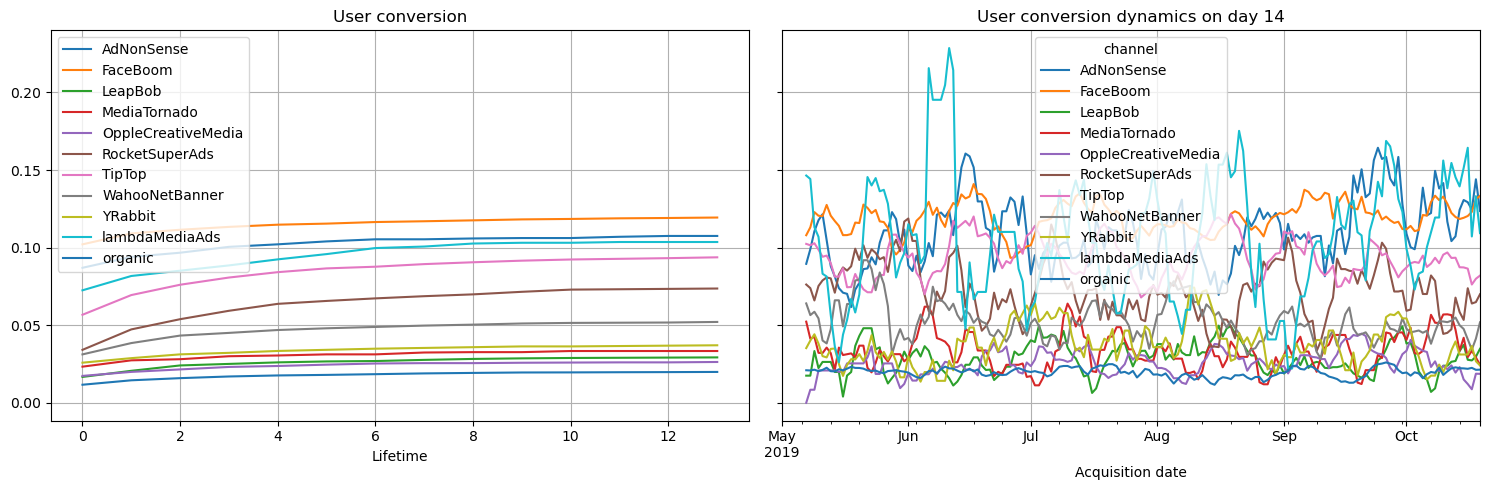

In [128]:
conversion_raw, conversion_reg, conversion_reg_history = get_conversion(
    users, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

plot_conversion(conversion_reg, conversion_reg_history, 14, window=7)

1. Conversion of users from FaceBoom and AdNonSense channels is about 12% and 10% over 14 days. This is 10% higher than the "others" group (channels bringing the fewest paying users).  
2. In dynamics, FaceBoom, AdNonSense, and TipTop channels show the highest conversion rates.  

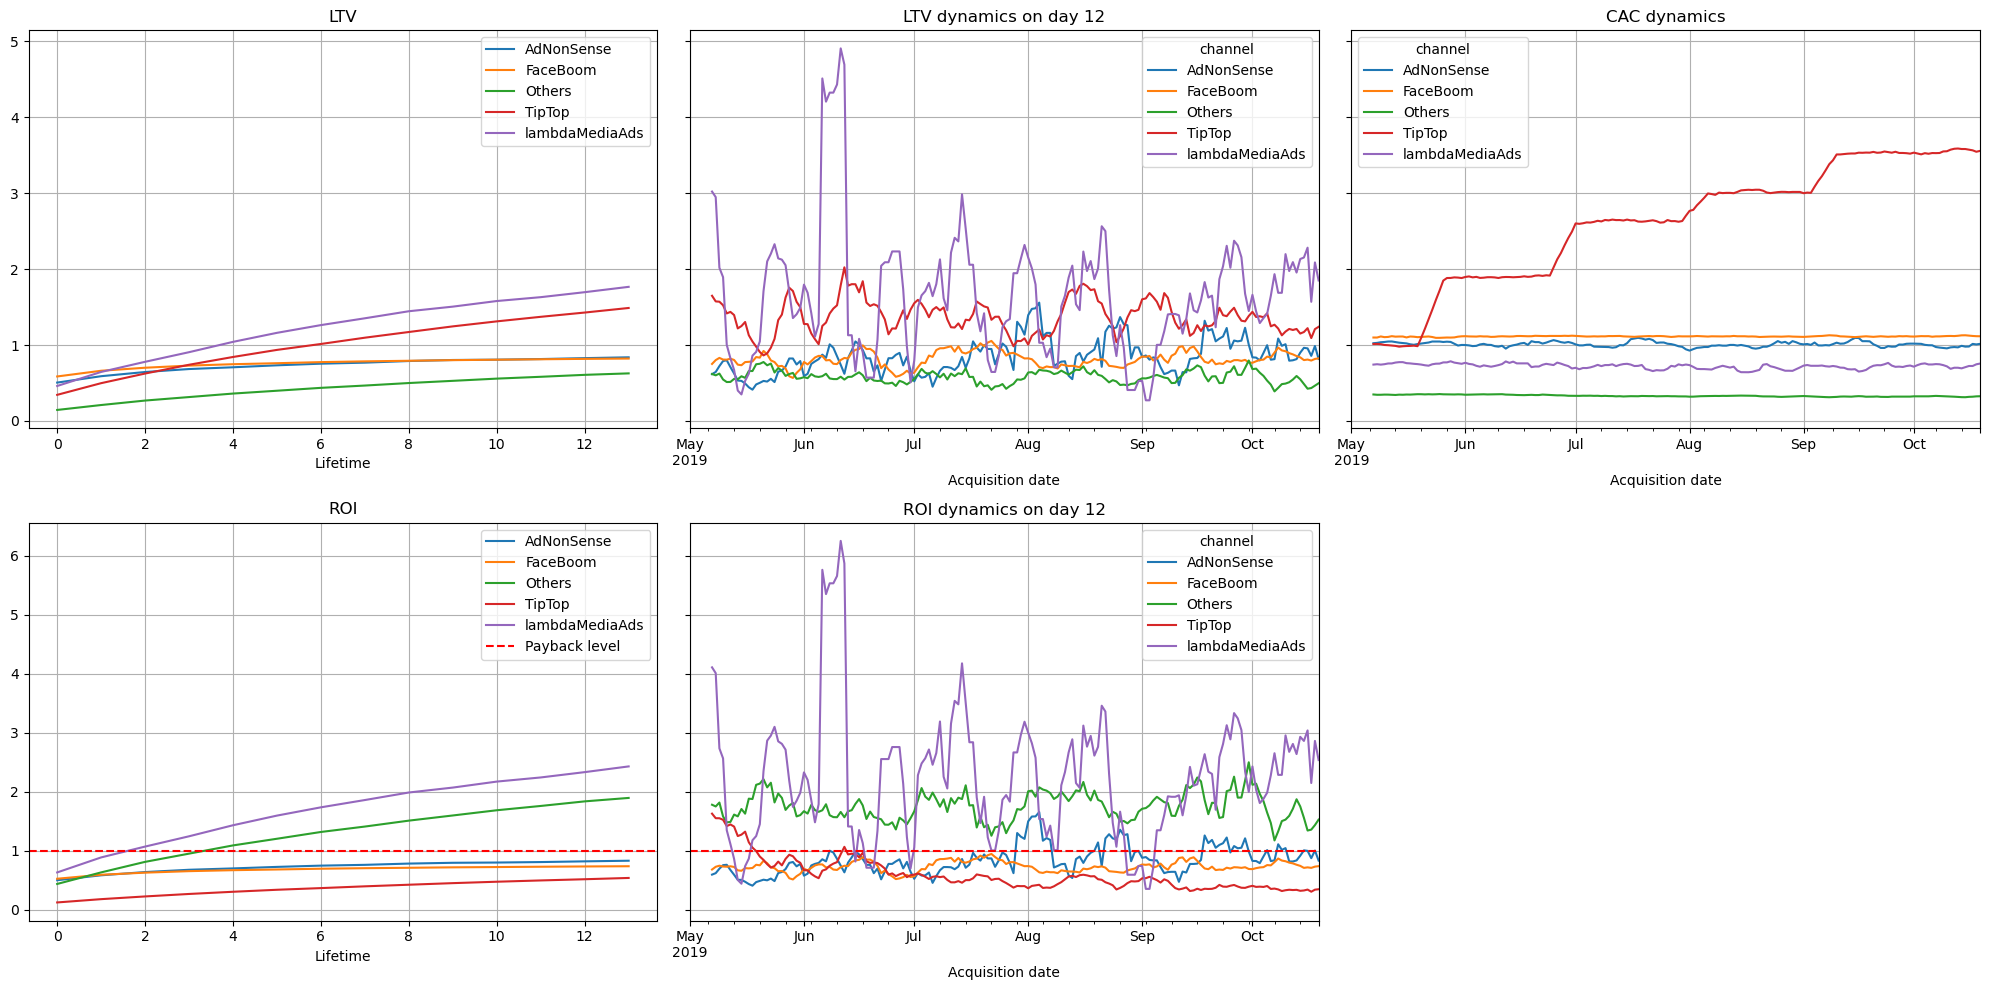

In [129]:
# calculate LTV, CAC, and ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    report,
    orders,
    datetime(2019, 11, 1).date(),
    14,
    dimensions=['channel'],
)

# plot charts
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 12)

1. LTV of users from the TipTop channel increases to 150% by the end of the second week.  
2. The next best are FaceBoom and AdNonSense.  
3. Across the entire period, these three channels also show the best LTV performance.  
4. The cost of acquiring clients through TipTop is about 3 times higher than others, and expenses are not recouped by the end of the second week.  
5. The only channels that break even are in the combined "Others" group, since they require the least spending. No single channel achieves payback within 14 days.  
6. Over the full period, AdNonSense showed good payback in August and mid-September. TipTop demonstrates the lowest payback.  

#### Conclusion for this section:
1. CAC grew by 30% in June compared to May and continued to increase by +70% relative to the beginning of the reporting period.  
2. ROI is close but does not reach the payback threshold by the end of the second week. Advertising is not profitable.  
3. Looking at the 8th-day dynamics over a six-month horizon, marketing payback is declining.  
4. The last "successful" advertising investment period was in May.  
5. RR for paying users drops by 10% immediately after the first day, the same as for non-paying users.  
6. The highest RR by the end of the second week for paying users was in early June and late May.  
7. Overall conversion increased starting from June, coinciding with the increase in the advertising budget.  
8. Retention of PC users among paying clients is much higher than that of users of other devices.  
9. Retention of US users is the lowest, even though they represent the largest and most paying segment.  
10. The cost of acquiring US users is almost 60% higher than for others.  
11. LTV of US users is the highest.  
12. Conversion of US users is 40% higher than others, reaching nearly 70% by the end of the second week.  
13. Retention is highest among users acquired through the TipTop channel. The second place goes to AdNonSense, which brings in the most paying clients.  
14. Conversion of users from FaceBoom and AdNonSense channels is about 12% and 10% over 14 days.  
15. LTV of TipTop users grows to 150% by the end of the second week.  
16. Over the full period, AdNonSense showed good payback in August and mid-September. TipTop demonstrates the lowest payback.  
17. The cost of acquiring clients through TipTop is about 3 times higher than the others.  

### General Conclusions

1. It is necessary to reconsider the allocation of advertising spend across channels.  

a) **TipTop channel** ($54,000 invested, nearly 50% of the marketing budget).  
   - Highest CAC — nearly $3.  
   - LTV = 110.  
   - Share of paying clients: 9%.  
   - Strong RR for paying users on day 2 (50%), dropping to just above 20% by the end of the second week.  
   - Conversion on day 14: 10%.  
   - ROI = 50%.  
   - Since mid-May, this channel has not reached the payback level.  

b) **AdNonSense and lambdaMediaAd channels** ($4,000 and $1,600 invested respectively).  
   - Bring a higher share of paying clients: 11% and 10%.  
   - Conversion on day 14: ~10%.  
   - AdNonSense retention needs improvement: since early May, RR dropped by 25%, current RR on day 14 is below 5%.  
   - lambdaMediaAd has a stronger RR on day 14 at ~20%.  

c) **FaceBoom channel** ($33,000 invested — 1.5 times less than TipTop).  
   - Largest share of paying clients: 12%.  
   - Highest conversion on day 14: ~13%.  
   - Very weak retention (RR on day 14 ~2%). This channel requires special attention.  

2. The majority of users use **iPhone (36%)** and **PC (20%)**.  
   - Retention of paying iPhone users is lower than that of PC users: RR on day 14 is 9% vs 12%.  
   - This may point to app-related issues; an update or optimization may be needed.  

3. **US users** (the largest regional group — 66.7% of all users).  
   - RR on day 14 = 10% (10% lower than other regions).  
   - CAC = $1.8 — almost double compared to other regions.  
   - Average share of paying clients = 6%.  
   - Conversion on day 14 is the highest — nearly 7%.  

4. **Other regions (UK, Germany)** show stronger results:  
   - RR on day 14 ~20% (about 10% higher than the US).  
   - Conversion on day 14 = 4%.  
   - Share of paying clients ~4% of all regional users.  